Connect to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Load X numpy array ( images), and Y numpy array (labels)

In [ ]:
import numpy as np
X=np.load("Path to X.npy")
Y=np.load("Path to Y.npy")

Visualize an image sample

[8.]


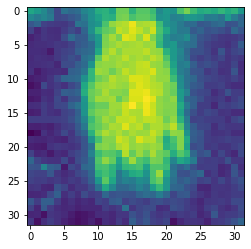

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(X[2798,:,:,0])
print(Y[2798])

Create test (20%) and train dataset. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

print(Y_test.shape)
a=[0,0,0,0,0,0,0,0,0,0]
for i in range(Y_test.shape[0]):
  a[int(Y_test[i])]=a[int(Y_test[i])]+1
print(a)

(640, 1)
[64, 64, 64, 64, 64, 64, 64, 64, 64, 64]


Model Description

In [ ]:
import tensorflow as tf
from tensorflow import Tensor
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.python.keras.models import Model

initializer = tf.keras.initializers.HeNormal()

def scheduler(epoch, lr):
  if (epoch%8)==0:
    return lr * tf.math.exp(-0.1)
  else:
    return lr

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def relu_u(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    #bn = BatchNormalization()(relu)
    return relu

def bottleneck(x: Tensor, kernels:int, dilation: int) -> Tensor:
    
   
    y = Conv2D(kernel_size=1,
               strides= 1,
               filters=int(kernels/4),
               padding="same",kernel_initializer=initializer)(x)
    y = relu_bn(y)
    
    y = Conv2D(kernel_size=3,
               strides=1,
               filters=int(kernels/4),
               padding="same",kernel_initializer=initializer)(y)
    y = relu_bn(y)
    
    y = Conv2D(kernel_size=1,
               strides= 1,
               filters=kernels,
               padding="same",kernel_initializer=initializer)(y)
    y = relu_bn(y)
    
    out = Add()([x, y])
    
    y1 = Conv2D(kernel_size=1,
               strides= 1,
               filters=int(kernels/4),
               padding="same",kernel_initializer=initializer)(out)
    y1 = relu_bn(y1)
    
    y1 = Conv2D(kernel_size=3,
               strides=1,
               filters=int(kernels/4),
               dilation_rate=dilation,
               padding="same",kernel_initializer=initializer)(y1)
    y1 = relu_bn(y1)
    
    y1 = Conv2D(kernel_size=1,
               strides= 1,
               filters=kernels,
               padding="same",kernel_initializer=initializer)(y1)
    y1 = relu_bn(y1)
    
    out1 = Add()([out, y1])   

    return out1

def create_net():
    
    inputs = Input(shape=(32,32,1))
    
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=64,
               padding="valid",kernel_initializer=initializer)(inputs)
    t = relu_bn(t)
    
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=128,
               padding="valid",kernel_initializer=initializer)(t)
    t = relu_bn(t)
    
    t = bottleneck(t,kernels=128,dilation=2)
    
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=256,
               padding="valid",kernel_initializer=initializer)(t)
    t = relu_bn(t)
    
    t = bottleneck(t,kernels=256,dilation=4)
    
    
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=128,
               padding="same",kernel_initializer=initializer)(t)
    t = relu_bn(t)

    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
net = create_net()
print(net.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 15, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 15, 15, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 15, 15, 64)   256         re_lu[0][0]                      
_______________________________________________________________________________________

Train the model

In [ ]:
net = create_net()
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
a=net.fit(X_train,Y_train,batch_size=8,epochs=20,validation_split=0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
288/288 [==============================] - 4s 12ms/step - loss: 1.3379 - accuracy: 0.6159 - val_loss: 1.1081 - val_accuracy: 0.7500
Epoch 2/20
288/288 [==============================] - 3s 11ms/step - loss: 0.3723 - accuracy: 0.8828 - val_loss: 0.3038 - val_accuracy: 0.9062
Epoch 3/20
288/288 [==============================] - 3s 11ms/step - loss: 0.1981 - accuracy: 0.9293 - val_loss: 0.0994 - val_accuracy: 0.9766
Epoch 4/20
288/288 [==============================] - 3s 11ms/step - loss: 0.0619 - accuracy: 0.9813 - val_loss: 0.0709 - val_accuracy: 0.9727
Epoch 5/20
288/288 [==============================] - 3s 11ms/step - loss: 0.1279 - accuracy: 0.9627 - val_loss: 0.2481 - val_accuracy: 0.9414
Epoch 6/20
288/288 [==============================] - 3s 11ms/step - loss: 0.1452 - accuracy: 0.9575 - val_loss: 0.4160 - val_accuracy: 0.9023
Epoch 7/20
288/288 [==============================] - 3s 11ms/step - loss: 0.0336 - accuracy: 0.9887 - val_loss: 0.0532 - val_accuracy: 0.9844

Evaluate the model

In [ ]:
print("Evaluate on test data")
results = net.evaluate(X_test, Y_test, batch_size=1)
print("test loss, test acc:", results)

Evaluate on test data
640/640 [==============================] - 3s 5ms/step - loss: 0.0143 - accuracy: 0.9953
test loss, test acc: [0.014308418147265911, 0.995312511920929]


Model accuracy and loss plot

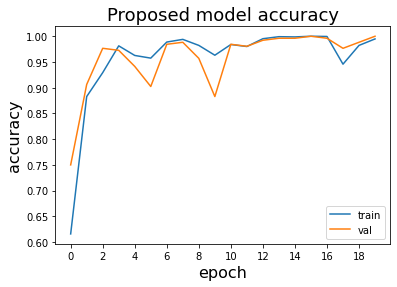

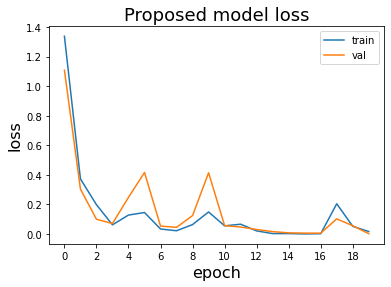

In [ ]:
history=a
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Proposed model accuracy',fontsize=18)
plt.ylabel('accuracy',fontsize=16)
plt.xlabel('epoch',fontsize=16)
plt.xticks(np.arange(0, 20, 2.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Proposed model loss', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(np.arange(0, 20, 2.0))
plt.legend(['train', 'val'], loc='upper right')
plt.show()

To save a keras model

In [ ]:
net.save('Path to save .h5 file')

Load a trained model

In [ ]:
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras
moe=keras.models.load_model('Path where trained .h5 file is stored')

In [ ]:
moe.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 15, 15, 64)   640         input_7[0][0]                    
__________________________________________________________________________________________________
re_lu_94 (ReLU)                 (None, 15, 15, 64)   0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 15, 15, 64)   256         re_lu_94[0][0]                   
______________________________________________________________________________________

Confusion matrix of loaded trained model

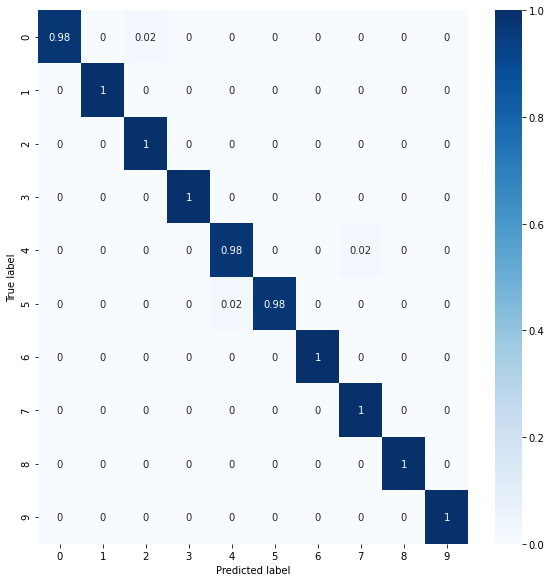

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        64
         1.0       1.00      1.00      1.00        64
         2.0       0.98      1.00      0.99        64
         3.0       1.00      1.00      1.00        64
         4.0       0.98      0.98      0.98        64
         5.0       1.00      0.98      0.99        64
         6.0       1.00      1.00      1.00        64
         7.0       0.98      1.00      0.99        64
         8.0       1.00      1.00      1.00        64
         9.0       1.00      1.00      1.00        64

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



0.9953125

In [ ]:
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras

y_=moe.predict(X_test)
y_pred=np.argmax(tf.nn.softmax(y_),axis=1)

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes=['0','1','2','3','4','5','6','7','8','9']
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)

To convert a keras model to tflite model

In [ ]:
import tensorflow as tf
from tensorflow import lite
from tensorflow import keras
mode = keras.models.load_model('path to model .h5 file')
#mode.save('/gdrive/My Drive/final_model_.h5')
converter = lite.TFLiteConverter.from_keras_model(mode)
tflite_model = converter.convert()

open('provide file name and path to store tflite model', 'wb').write(tflite_model)